In [1]:
# ----------- Libraries -----------------
import os, json
import sys
from pathlib import Path
import torch
import math
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

from copy import deepcopy
from torch import optim

from datasets import ensure_split, make_loaders
from model_unet import UNet
from losses import combo_bce_dice
from utils import set_seeds, CSVLogger, run_validation, eval_full_images, dice_iou_from_logits, plot_curves
from utils_viz import show_augmented_labeled, show_augmented_unlabeled, save_pred_grid




In [2]:
#-------------Config---------------------------


CFG = dict(
    seed=1337,
    patch_size=256,          # native-scale patch size (no resizing)
    batch_size=4,
    epochs_sup=80,
    epochs_ssl=120,
    lr=1e-3,
    weight_decay=1e-4,
    lambda_u_max=5.0,  # SSL consistency weight (max)
    ema_alpha=0.99, # EMA decay for teacher
    ramp_epochs=20,  # ramp-up epochs for lambda_u
    num_workers=4,
    roi=dict(y1=370, y2=1138, x1=200, x2=968),  # ROI crop unlabeled (and labeled if needed) to this region
    paths=dict(
        labeled_dir="data/labeled",      # images+masks
        unlabeled_dir="data/unlabeled",  # images only
        split_json="data/splits/split.json",
        run_dir="runs/exp02",
        ckpt_dir="checkpoints",
    )
)

#-----------device selection------------------------

# We want to train on the GPU, so we pick a GPU; 'cuda' = default GPU; 
# 'cuda:0', 'cuda:1' for a specific one, as in this case the computer where it will run has 2. We use one of them (NVIDIA GeForce RTX 3090).
if torch.cuda.is_available():
    device = torch.device("cuda:1")  # Use GPU
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")  # Use CPU if GPU is not available
    print("Using CPU")

# reproducibility

set_seeds(CFG["seed"])
Path(CFG["paths"]["run_dir"]).mkdir(parents=True, exist_ok=True)
Path(CFG["paths"]["ckpt_dir"]).mkdir(parents=True, exist_ok=True)


Using GPU: NVIDIA GeForce RTX 3090


In [3]:
# -------------Data -------------------------------
ensure_split(CFG)
loaders = make_loaders(CFG)

b = next(iter(loaders["labeled"]))
print("weak  min/max:", float(b["x_w"].min()), float(b["x_w"].max()))
print("strong min/max:", float(b["x_s"].min()), float(b["x_s"].max()))
print("mask   min/max:", float(b["y"].min()),   float(b["y"].max()))


weak  min/max: 0.0 1.0
strong min/max: 0.0 1.0
mask   min/max: 0.0 1.0


In [4]:
ensure_split(CFG)
loaders = make_loaders(CFG)

b_l = next(iter(loaders["labeled"]))
b_u = next(iter(loaders["unlabeled"]))
print("LAB", b_l["x_w"].shape, b_l["x_s"].shape, b_l["y"].shape, b_l["x_w"].min().item(), b_l["x_w"].max().item())
print("UNL", b_u["x_w"].shape, b_u["x_s"].shape, b_u["x_s"].min().item(), b_u["x_s"].max().item())


LAB torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256]) 0.0 1.0
UNL torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256]) 0.0 1.0


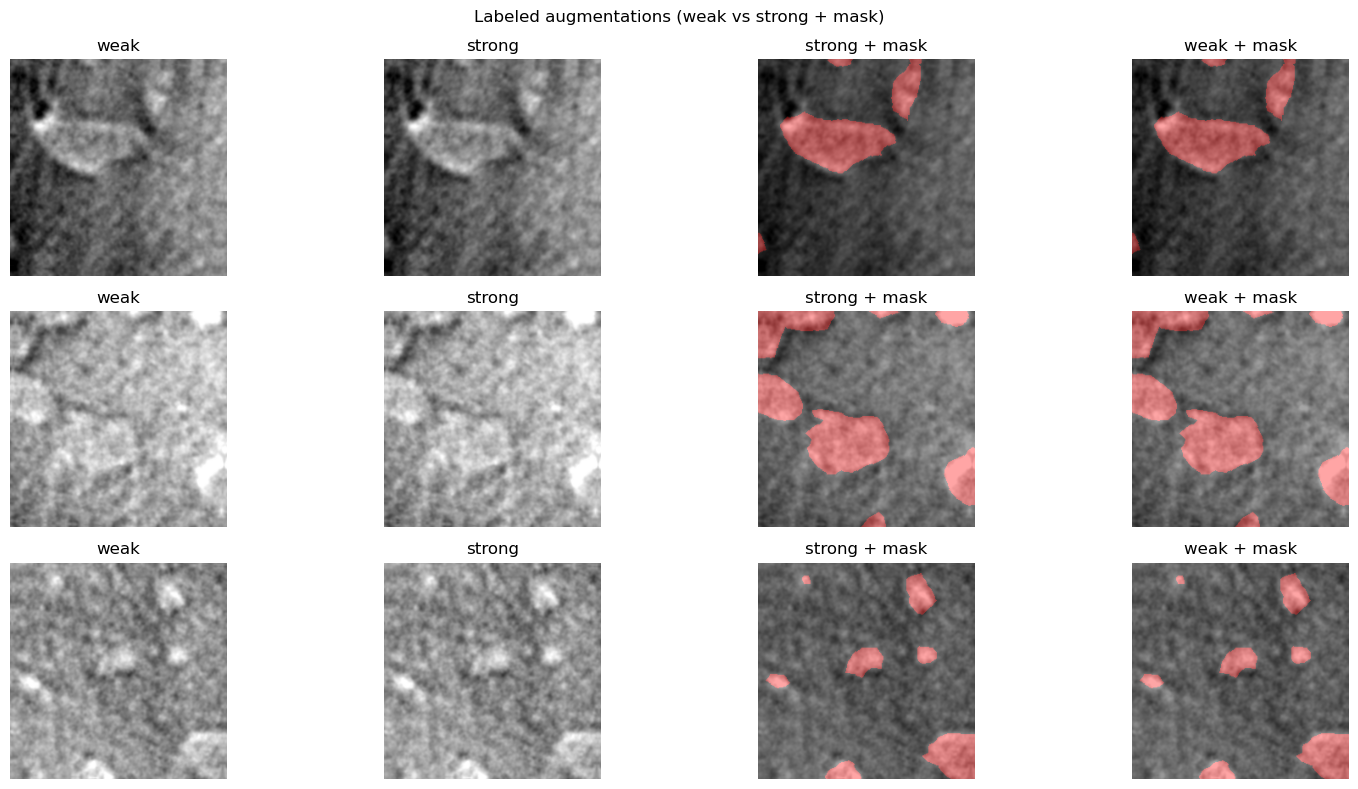

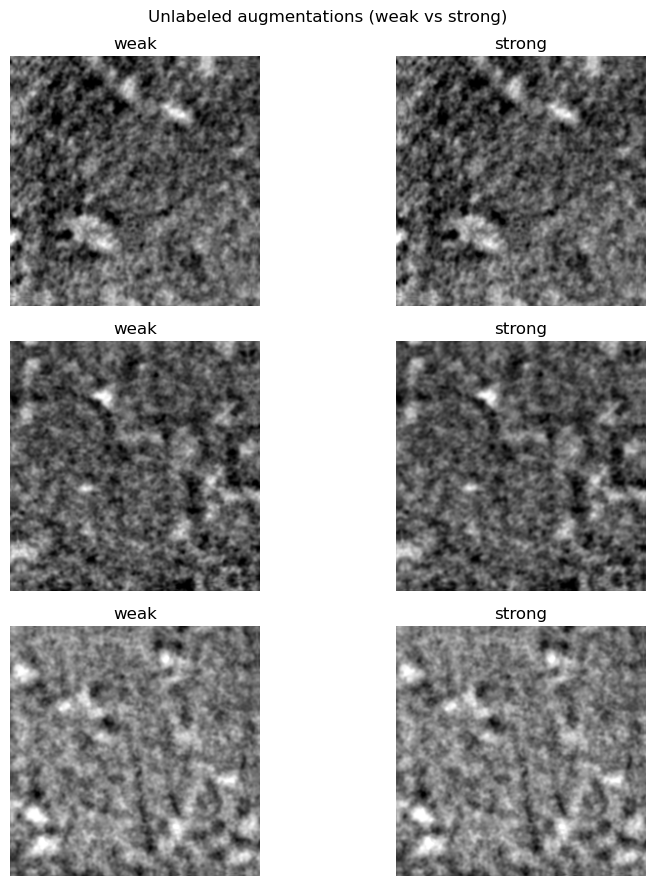

In [5]:
from utils_viz import show_augmented_labeled, show_augmented_unlabeled
b_lab = next(iter(loaders["labeled"]))
b_unl = next(iter(loaders["unlabeled"]))
show_augmented_labeled(b_lab, n=3)     # should see same structures in weak/strong, masks aligned
show_augmented_unlabeled(b_unl, n=3)   # weak vs strong same crop, different intensity


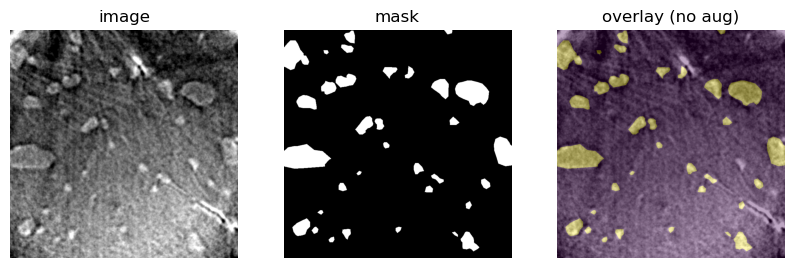

In [6]:
from pathlib import Path
from datasets import preprocess_pipeline

# Pick one known labeled pair
img_path  = Path(CFG["paths"]["labeled_dir"])/"Original_images"/"image_v2_00.tif"
mask_path = Path(CFG["paths"]["labeled_dir"])/"Original_masks"/"mask_000_inv.npy"  # or .png/.tif # or .tif/.png

ip, mp = preprocess_pipeline(img_path, mask_path, roi=None)  # NO ROI, NO AUG
img = np.array(ip, dtype=np.float32) / 255.0
msk = (np.array(mp) > 127).astype(np.float32)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray", vmin=0, vmax=1); plt.title("image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(msk, cmap="gray"); plt.title("mask"); plt.axis("off")
plt.subplot(1,3,3); 
plt.imshow(img, cmap="gray", vmin=0, vmax=1); plt.imshow(msk, alpha=0.35); 
plt.title("overlay (no aug)"); plt.axis("off")
plt.show()


In [7]:
# show which mask is being paired for the first few samples
ds = loaders["labeled"].dataset  # or rebuild loaders after editing
for k in range(3):
    rec = ds.samples[k]
    print("IMG:", rec["img"])
    print("MSK:", rec["mask"])


IMG: data/labeled/Original_images/image_v2_13.tif
MSK: data/labeled/Original_masks/mask_013_inv.npy
IMG: data/labeled/Original_images/image_v2_03.tif
MSK: data/labeled/Original_masks/mask_003_inv.npy
IMG: data/labeled/Original_images/image_v2_06.tif
MSK: data/labeled/Original_masks/mask_006_inv.npy


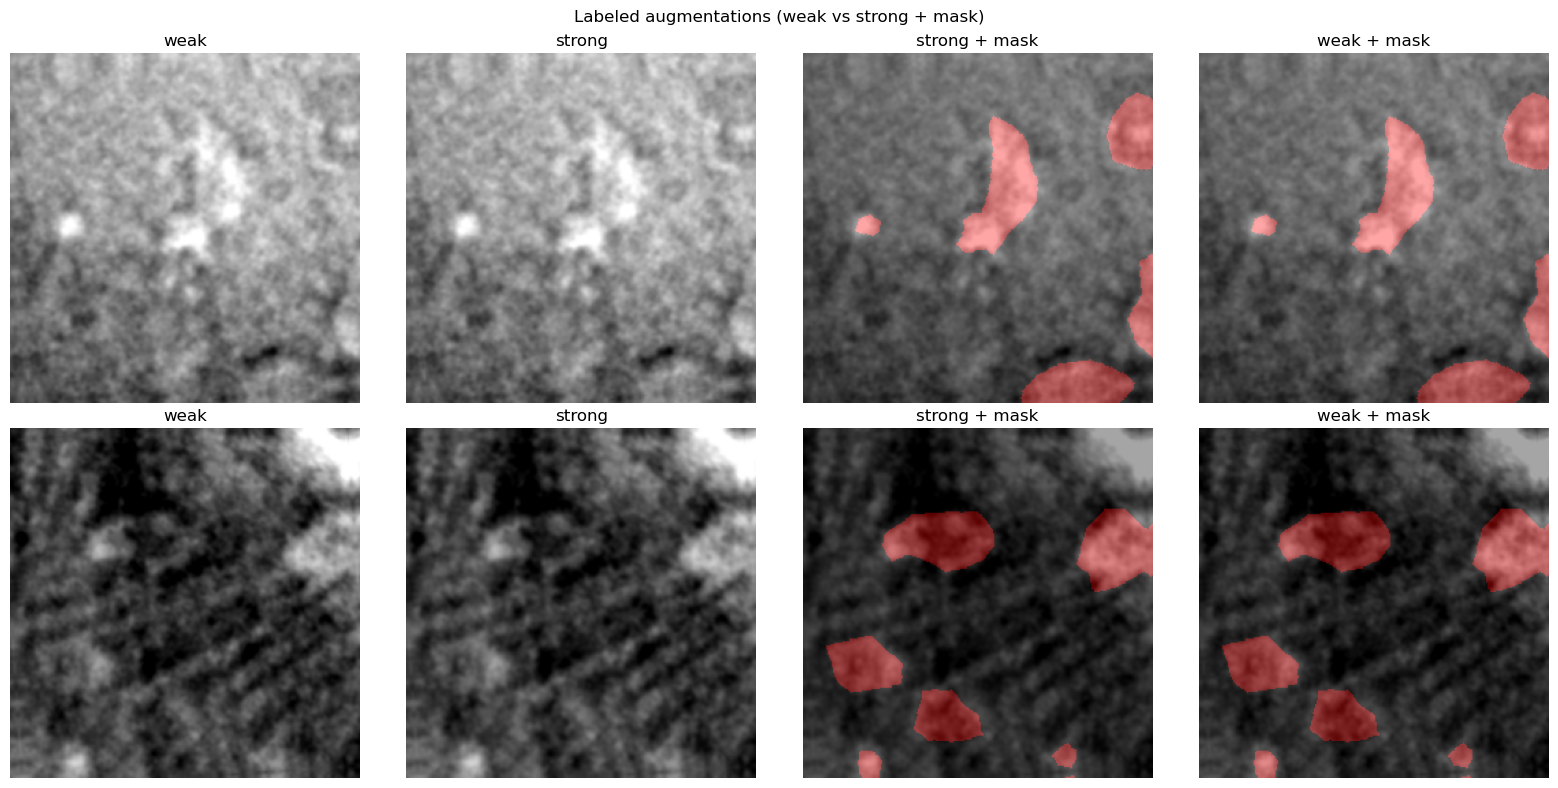

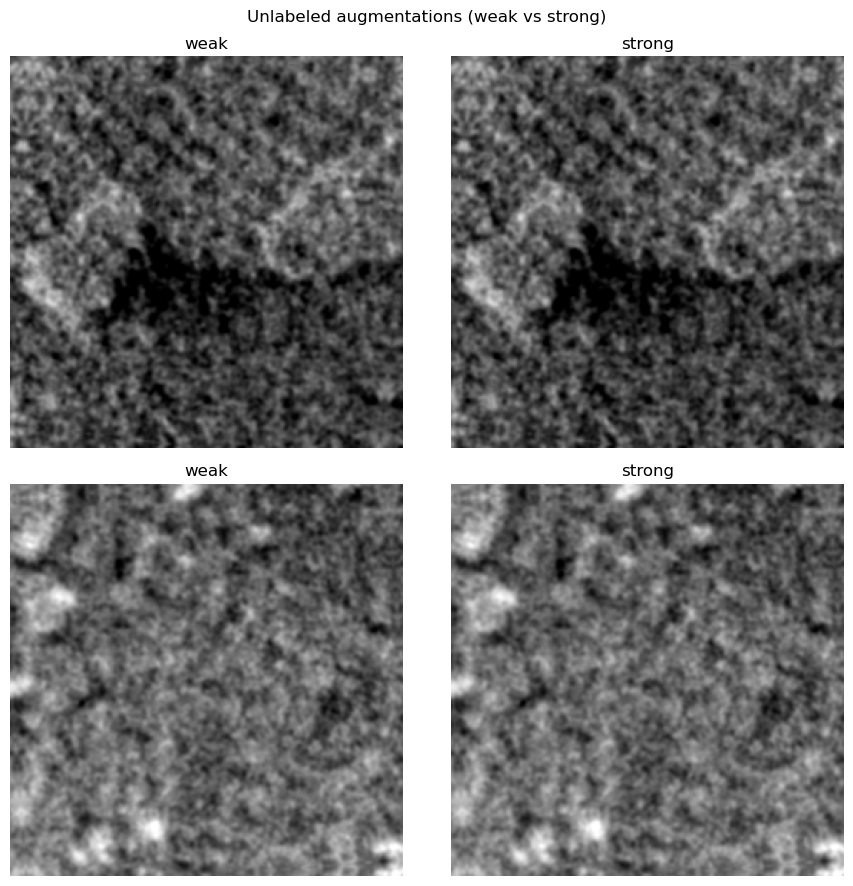

In [8]:
# -------------Data -------------------------------
ensure_split(CFG)
loaders = make_loaders(CFG)

# 2) Grab a batch and visualize (new, clearer style)
from utils_viz import show_augmented_labeled, show_augmented_unlabeled

b_lab = next(iter(loaders["labeled"]))
b_unl = next(iter(loaders["unlabeled"]))

show_augmented_labeled(b_lab, n=2)     # n = how many rows to show
show_augmented_unlabeled(b_unl, n=2)

In [ ]:
#from datasets import preprocess_pipeline
#from pathlib import Path
#import numpy as np

# Pick one known labeled pair
#img_path  = Path(CFG["paths"]["labeled_dir"])/"Original_images"/"image_v2_00.tif"
#mask_path = Path(CFG["paths"]["labeled_dir"])/"Original_masks"/"mask_000_inv.npy"  # or .png/.tif

#ip, mp = preprocess_pipeline(img_path, mask_path, roi=CFG.get("roi"))
#img = np.array(ip, dtype=np.float32)/255.0
#msk = (np.array(mp)>127).astype(np.uint8)

#print("preproc image min/max:", img.min(), img.max(), "mean:", img.mean())
#print("mask min/max:", msk.min(), msk.max(), "fg frac:", msk.mean())


In [ ]:
#from datasets import preprocess_pipeline
#from pathlib import Path
#ip, mp = preprocess_pipeline(
#    Path(CFG["paths"]["labeled_dir"])/"Original_images"/"image_v2_00.tif",
#    Path(CFG["paths"]["labeled_dir"])/"Original_masks"/"mask_000_inv.npy",
#    roi=CFG.get("roi")  # try with and without
#)
#a = np.array(ip, dtype=np.float32)/255.0
#m = (np.array(mp)>127).astype(np.uint8)
#print("img min/max/mean:", a.min(), a.max(), a.mean())
#print("mask unique:", np.unique(m), "fg frac:", m.mean())


img min/max/mean: 0.0 1.0 0.3903552
mask unique: [0 1] fg frac: 0.05247186637412414


In [ ]:
#import numpy as np
#from pathlib import Path

#mp = Path(CFG["paths"]["labeled_dir"])/"Original_masks"/"mask_000_inv.npy"
#m = np.load(mp)
#print("dtype:", m.dtype, "min:", m.min(), "max:", m.max(), "unique:", np.unique(m))
#print("fg fraction:", m.mean())  # should be fraction of ones if fg=1


dtype: float32 min: 0.0 max: 1.0 unique: [0. 1.]
fg fraction: 0.09215461


In [9]:
# --------------------- Supervised training on a UNET -----------------------
sup_model = UNet(1, 1).to(device)

opt = optim.AdamW(
    sup_model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["weight_decay"]
)

logger = CSVLogger(
    os.path.join(CFG["paths"]["run_dir"], "sup_metrics.csv"),
    ["epoch", "loss_sup", "val_dice", "val_iou"]
)

best_dice = -1.0
ckpt_sup  = os.path.join(CFG["paths"]["ckpt_dir"], "best_supervised.pth")
os.makedirs(os.path.join(CFG["paths"]["run_dir"], "images"), exist_ok=True)

for epoch in range(1, CFG["epochs_sup"] + 1):
    sup_model.train()
    run_loss = 0.0

    for b in loaders["labeled"]:
        x = b["x"].to(device) if "x" in b else b["x_s"].to(device)
        y = b["y"].to(device)
        logits = sup_model(x)
        loss   = combo_bce_dice(logits, y, w_bce=0.5)
        opt.zero_grad(); loss.backward(); opt.step()
        run_loss += float(loss.item())

    run_loss /= max(1, len(loaders["labeled"]))
    val_d, val_i = run_validation(sup_model, loaders["val"], device)
    logger.log([epoch, run_loss, val_d, val_i])

    # 👇 add this
    print(f"[sup] epoch {epoch:03d} | train_loss={run_loss:.4f} | val_dice={val_d:.4f} | val_iou={val_i:.4f}")

    if epoch % 10 == 0:
        sup_model.eval()
        with torch.no_grad():
            vb  = next(iter(loaders["val"]))
            xx  = vb["x"].to(device)
            yy  = vb["y"].to(device)
            prb = torch.sigmoid(sup_model(xx))
            save_pred_grid(xx, yy, prb,
                os.path.join(CFG["paths"]["run_dir"], f"images/sup_epoch_{epoch}.png"))

    if val_d > best_dice:
        best_dice = val_d
        torch.save(sup_model.state_dict(), ckpt_sup)

logger.close()
print("Best supervised Dice:", best_dice)


[sup] epoch 001 | train_loss=0.6447 | val_dice=0.5196 | val_iou=0.3597
[sup] epoch 002 | train_loss=0.6103 | val_dice=0.4257 | val_iou=0.2751
[sup] epoch 003 | train_loss=0.5385 | val_dice=0.5674 | val_iou=0.4069
[sup] epoch 004 | train_loss=0.4915 | val_dice=0.5869 | val_iou=0.4309
[sup] epoch 005 | train_loss=0.5236 | val_dice=0.5431 | val_iou=0.3831
[sup] epoch 006 | train_loss=0.5132 | val_dice=0.6105 | val_iou=0.4559
[sup] epoch 007 | train_loss=0.4312 | val_dice=0.6022 | val_iou=0.4562
[sup] epoch 008 | train_loss=0.4329 | val_dice=0.6384 | val_iou=0.4947
[sup] epoch 009 | train_loss=0.4182 | val_dice=0.6761 | val_iou=0.5411
[sup] epoch 010 | train_loss=0.4117 | val_dice=0.6987 | val_iou=0.5630
[sup] epoch 011 | train_loss=0.3896 | val_dice=0.5838 | val_iou=0.4315
[sup] epoch 012 | train_loss=0.4091 | val_dice=0.5465 | val_iou=0.3989
[sup] epoch 013 | train_loss=0.4434 | val_dice=0.6459 | val_iou=0.5037
[sup] epoch 014 | train_loss=0.3932 | val_dice=0.6672 | val_iou=0.5294
[sup] 

In [10]:
# --------------------- Semi-supervised (Mean-Teacher) -----------------------
student = UNet(1, 1).to(device)
teacher = UNet(1, 1).to(device)

# init from best supervised weights
student.load_state_dict(torch.load(ckpt_sup, map_location=device))
teacher.load_state_dict(torch.load(ckpt_sup, map_location=device))
for p in teacher.parameters():
    p.requires_grad_(False)  # teacher is EMA, not trained by grad

opt_ssl = optim.AdamW(student.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

ema_momentum = CFG.get("ema_momentum", 0.99)          # e.g., 0.99–0.999
lambda_max   = CFG.get("consistency_weight", 1.0)      # final weight for consistency
ramp_epochs  = CFG.get("consistency_ramp_epochs", 10)  # ramp-up duration

def ramp(t, T):  # smooth ramp 0->1 over T epochs
    if T <= 0: return 1.0
    x = np.clip(t / float(T), 0.0, 1.0)
    return float(0.5 - 0.5 * np.cos(np.pi * x))  # cosine ramp

mse = torch.nn.MSELoss()

epochs_ssl = CFG.get("epochs_ssl", 40)
for epoch in range(1, epochs_ssl + 1):
    student.train()
    teacher.eval()

    sup_run, cons_run = 0.0, 0.0
    lam = lambda_max * ramp(epoch, ramp_epochs)

    # make a persistent iterator over unlabeled
    unl_iter = iter(loaders["unlabeled"])

    for b_l in loaders["labeled"]:
        # ----- supervised step on labeled (use strong if present) -----
        xs = b_l["x_s"].to(device) if "x_s" in b_l else b_l["x"].to(device)
        y  = b_l["y"].to(device)

        s_logits = student(xs)
        loss_sup = combo_bce_dice(s_logits, y, w_bce=0.5)

        # ----- consistency step on unlabeled (teacher weak vs student strong) -----
        try:
            b_u = next(unl_iter)
        except StopIteration:
            unl_iter = iter(loaders["unlabeled"])
            b_u = next(unl_iter)

        xw_u = b_u["x_w"].to(device) if "x_w" in b_u else b_u["x"].to(device)   # teacher input (weak)
        xs_u = b_u["x_s"].to(device) if "x_s" in b_u else b_u["x"].to(device)   # student input (strong)

        with torch.no_grad():
            t_logits = teacher(xw_u)
            t_probs  = torch.sigmoid(t_logits)  # soft targets (no hard threshold)

        s_logits_u = student(xs_u)
        s_probs_u  = torch.sigmoid(s_logits_u)

        loss_cons = mse(s_probs_u, t_probs)

        # ----- total loss & step -----
        loss_total = loss_sup + lam * loss_cons

        opt_ssl.zero_grad()
        loss_total.backward()
        opt_ssl.step()

        # ----- EMA update for teacher -----
        with torch.no_grad():
            m = ema_momentum
            for p_t, p_s in zip(teacher.parameters(), student.parameters()):
                p_t.data.mul_(m).add_(p_s.data, alpha=1.0 - m)

        sup_run  += float(loss_sup.item())
        cons_run += float(loss_cons.item())

    sup_run  /= max(1, len(loaders["labeled"]))
    cons_run /= max(1, len(loaders["labeled"]))

    # validation with student
    val_d, val_i = run_validation(student, loaders["val"], device)
    print(f"[ssl] epoch {epoch:03d} | sup={sup_run:.4f} | cons={cons_run:.4f} | lam={lam:.2f} | val_dice={val_d:.4f} | val_iou={val_i:.4f}")

    # save best by val Dice
    ckpt_ssl = os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_student.pth")
    if epoch == 1 or val_d >= getattr(best_ssl_dice := locals().get("best_ssl_dice", -1.0), "real", best_ssl_dice):
        best_ssl_dice = val_d
        torch.save(student.state_dict(), ckpt_ssl)



/tmp/ipykernel_1313427/404170095.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(ckpt_sup, map_location=device))
/tmp/ipykernel_131342

[ssl] epoch 001 | sup=0.3968 | cons=0.0232 | lam=0.02 | val_dice=0.7555 | val_iou=0.6291
[ssl] epoch 002 | sup=0.3124 | cons=0.0488 | lam=0.10 | val_dice=0.6515 | val_iou=0.5140
[ssl] epoch 003 | sup=0.3049 | cons=0.0570 | lam=0.21 | val_dice=0.6713 | val_iou=0.5340
[ssl] epoch 004 | sup=0.3969 | cons=0.0387 | lam=0.35 | val_dice=0.7002 | val_iou=0.5632
[ssl] epoch 005 | sup=0.3045 | cons=0.0287 | lam=0.50 | val_dice=0.6701 | val_iou=0.5329
[ssl] epoch 006 | sup=0.2717 | cons=0.0334 | lam=0.65 | val_dice=0.7139 | val_iou=0.5870
[ssl] epoch 007 | sup=0.3228 | cons=0.0141 | lam=0.79 | val_dice=0.7469 | val_iou=0.6204
[ssl] epoch 008 | sup=0.3799 | cons=0.0134 | lam=0.90 | val_dice=0.7457 | val_iou=0.6174
[ssl] epoch 009 | sup=0.3072 | cons=0.0114 | lam=0.98 | val_dice=0.7409 | val_iou=0.6149
[ssl] epoch 010 | sup=0.2850 | cons=0.0125 | lam=1.00 | val_dice=0.7017 | val_iou=0.5715
[ssl] epoch 011 | sup=0.3141 | cons=0.0182 | lam=1.00 | val_dice=0.6818 | val_iou=0.5517
[ssl] epoch 012 | sup

In [15]:
import os, pandas as pd
rd = CFG["paths"]["run_dir"]
print("run_dir:", rd)
for fn in ["sup_metrics.csv", "ssl_metrics.csv"]:
    p = os.path.join(rd, fn)
    print(fn, "| exists:", os.path.exists(p), "| size:", os.path.getsize(p) if os.path.exists(p) else "—")
    if os.path.exists(p) and os.path.getsize(p) > 0:
        try:
            print(pd.read_csv(p).head())
        except Exception as e:
            print(fn, "read error:", e)


run_dir: runs/exp01
sup_metrics.csv | exists: True | size: 6356
   epoch  loss_sup  val_dice   val_iou
0      1  2.012239  0.375336  0.232126
1      2  1.985693  0.432481  0.276839
2      3  1.864075  0.497631  0.331733
3      4  1.641078  0.471597  0.309809
4      5  1.710332  0.409606  0.258676
ssl_metrics.csv | exists: True | size: 0


In [6]:
import json
split = json.load(open(CFG["paths"]["split_json"]))
print("test IDs:", split["test"])
# Or list actual paths:
for rec in loaders["test_full"].dataset.samples:
    print(rec["img"], "↔", rec["mask"])


test IDs: ['image_v2_21', 'image_v2_07', 'image_v2_02', 'image_v2_00']
data/labeled/Original_images/image_v2_21.tif ↔ data/labeled/Original_masks/mask_021_inv.npy
data/labeled/Original_images/image_v2_07.tif ↔ data/labeled/Original_masks/mask_007_inv.npy
data/labeled/Original_images/image_v2_02.tif ↔ data/labeled/Original_masks/mask_002_inv.npy
data/labeled/Original_images/image_v2_00.tif ↔ data/labeled/Original_masks/mask_000_inv.npy


/tmp/ipykernel_1313427/2422238392.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_stu

Full-ROI — Dice 0.6782 | IoU 0.5131


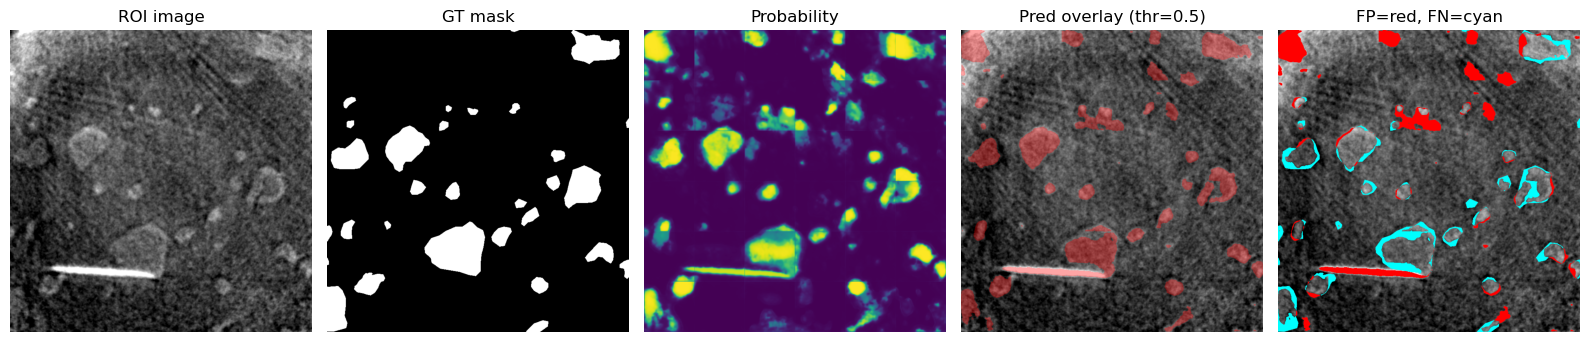

In [19]:
import os, math, numpy as np, torch, matplotlib.pyplot as plt
from PIL import Image
from model_unet import UNet
from datasets import preprocess_pipeline
from utils import dice_iou_from_logits  # expects logits

# --- optional: store ROIs distinctly in your CFG ---
# CFG["roi_unlabeled"] = {"y1":370,"y2":1138,"x1":200,"x2":968}
# (for labeled/test, we'll automatically use roi=None)

def predict_full_image(model, img_path, roi=None, patch=256, overlap=0.5, device="cpu"):
    ip  = preprocess_pipeline(img_path, roi=roi)              # PIL uint8 (0..255)
    img = np.array(ip).astype(np.float32)
    H, W = img.shape
    stride = max(1, int(patch * (1 - overlap)))

    # pad reflect so edges are covered
    def pad_to_cover(L):
        return (math.ceil((L - patch)/stride)*stride + patch) - L if L > patch else (patch - L)
    ph, pw = pad_to_cover(H), pad_to_cover(W)
    ph0, pw0 = ph//2, pw//2
    pad = np.pad(img, ((ph0, ph-ph0), (pw0, pw-pw0)), mode="reflect")
    Hp, Wp = pad.shape

    # (simple averaging; you can swap to Hann blending later)
    acc = np.zeros((Hp, Wp), np.float32)
    cnt = np.zeros((Hp, Wp), np.float32)

    model.eval()
    with torch.no_grad():
        for y in range(0, Hp - patch + 1, stride):
            for x in range(0, Wp - patch + 1, stride):
                tile = (pad[y:y+patch, x:x+patch] / 255.0).astype(np.float32)
                t = torch.from_numpy(tile)[None, None].to(device)
                p = torch.sigmoid(model(t)).cpu().numpy()[0,0]
                acc[y:y+patch, x:x+patch] += p
                cnt[y:y+patch, x:x+patch] += 1.0

    prob = acc / np.maximum(cnt, 1e-6)
    return prob[ph0:ph0+H, pw0:pw0+W]  # unpad to original (ROI) size

def plot_full_once(model, img_path, mask_path=None, patch=256, overlap=0.5, device="cpu"):
    # Auto-ROI: use none for labeled (mask given) or if path looks labeled; else unlabeled ROI
    if (mask_path is not None) or ("labeled" in str(img_path)):
        roi_use = None
    else:
        roi_use = CFG.get("roi_unlabeled") or CFG.get("roi")

    # Predict prob map
    prob = predict_full_image(model, img_path, roi=roi_use, patch=patch, overlap=overlap, device=device)

    # Load the visualization base image (same ROI decision), scale to 0..1
    img_roi = np.array(preprocess_pipeline(img_path, roi=roi_use)).astype(np.float32) / 255.0

    # If GT provided, load it through the same preprocess (so ROI matches)
    gt = None
    if mask_path is not None:
        _, mp = preprocess_pipeline(img_path, mask_path, roi=roi_use)
        gt = (np.array(mp) > 127).astype(np.float32)  # 0/1

    # Build overlays
    thr = 0.5
    pred = (prob > thr).astype(np.float32)
    rgb = np.stack([img_roi, img_roi, img_roi], axis=-1)

    def overlay(img_rgb, mask01, color=(1,0,0), alpha=0.35):
        out = img_rgb.copy()
        m = (mask01 > 0.5)
        tint = np.zeros_like(out); tint[...,0],tint[...,1],tint[...,2] = color
        out[m] = (1-alpha)*out[m] + alpha*tint[m]
        return np.clip(out, 0, 1)

    # Difference map if GT exists
    diff = None
    if gt is not None:
        tp = (pred==1) & (gt==1)
        fp = (pred==1) & (gt==0)
        fn = (pred==0) & (gt==1)
        diff = rgb.copy()
        diff[fp] = [1,0,0]   # red = FP
        diff[fn] = [0,1,1]   # cyan = FN

    # Metrics if GT exists (use logits for your helper)
    if gt is not None:
        eps = 1e-6
        logits = np.log(np.clip(prob, eps, 1-eps) / np.clip(1-prob, eps, 1-eps))
        d,i = dice_iou_from_logits(
            torch.from_numpy(logits[None,None]).float(),
            torch.from_numpy(gt[None,None]).float()
        )
        print(f"Full-ROI — Dice {d:.4f} | IoU {i:.4f}")

    # Plot
    cols = 4 if gt is None else 5
    fig, axs = plt.subplots(1, cols, figsize=(16, 7))
    for ax in axs: ax.set_aspect('equal'); ax.axis('off')

    axs[0].imshow(img_roi, cmap="gray", vmin=0, vmax=1); axs[0].set_title("ROI image")
    if gt is not None:
        axs[1].imshow(gt, cmap="gray", vmin=0, vmax=1); axs[1].set_title("GT mask")
        idx_prob = 2
    else:
        idx_prob = 1
    axs[idx_prob].imshow(prob, vmin=0, vmax=1); axs[idx_prob].set_title("Probability")
    axs[idx_prob+1].imshow(overlay(rgb, pred)); axs[idx_prob+1].set_title(f"Pred overlay (thr={thr})")
    if gt is not None:
        axs[idx_prob+2].imshow(diff, vmin=0, vmax=1); axs[idx_prob+2].set_title("FP=red, FN=cyan")
    plt.tight_layout(); plt.show()

# ---------- usage ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = UNet(1,1).to(device)
model.load_state_dict(torch.load(os.path.join(CFG["paths"]["ckpt_dir"], "best_ssl_student.pth"),
                                  map_location=device))
model.eval()

# Example A: labeled test image (has GT) → ROI is auto-skipped
rec = loaders["test_full"].dataset.samples[0]
plot_full_once(model, rec["img"], mask_path=rec["mask"],
               patch=CFG["patch_size"], overlap=0.5, device=device)

# Example B: an unlabeled big scan (no GT) → unlabeled ROI is used
# plot_full_once(model, "data/unlabeled/your_scan.tif",
#                mask_path=None, patch=CFG["patch_size"], overlap=0.5, device=device)


Full-ROI — Dice 0.6782 | IoU 0.5131


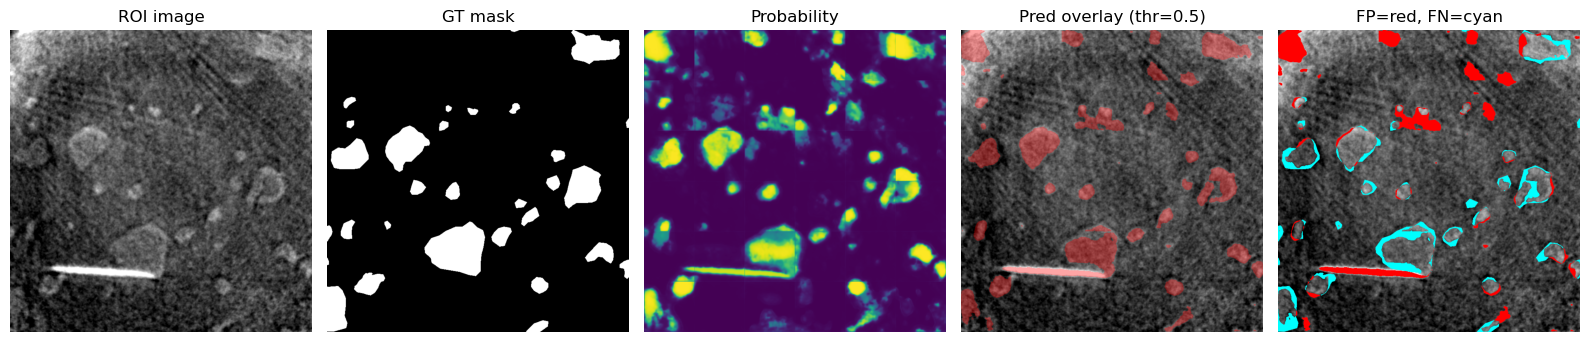

Full-ROI — Dice 0.7901 | IoU 0.6531


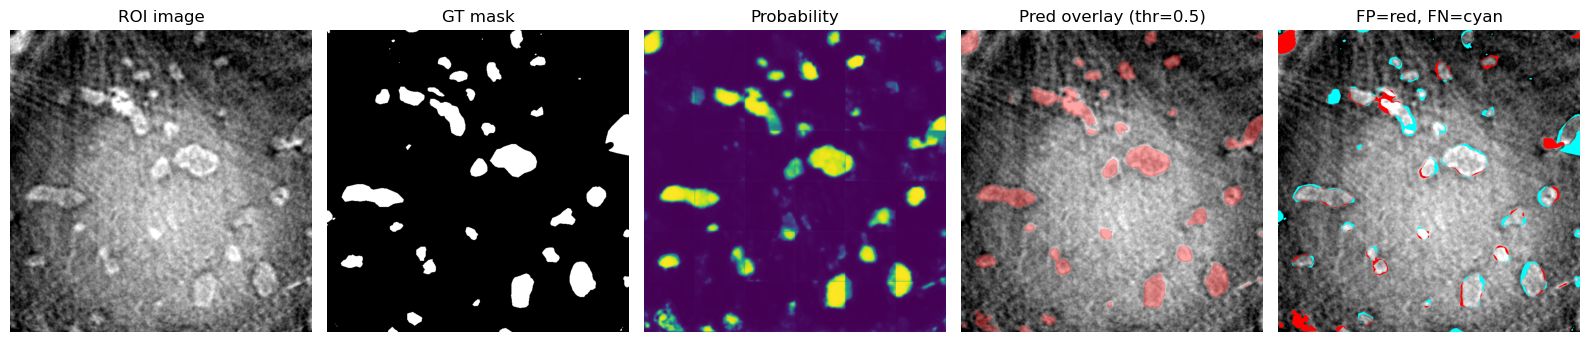

Full-ROI — Dice 0.7319 | IoU 0.5771


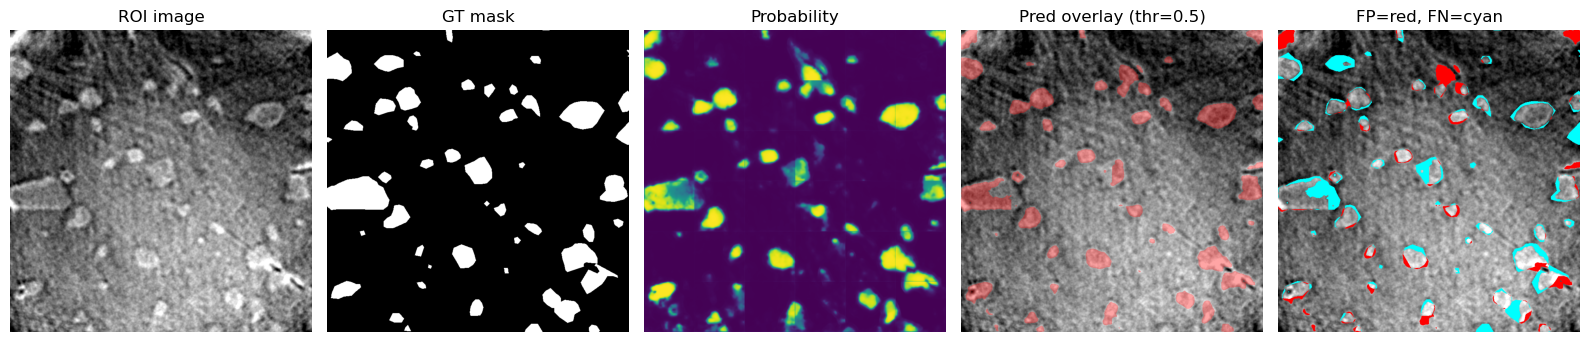

In [16]:
# show a few test images (full ROI, with GT overlays & Dice/IoU)
for i in range(3):   # change how many you want to view
    rec = loaders["test_full"].dataset.samples[i]
    plot_full_once(
        model,
        img_path=rec["img"],
        mask_path=rec["mask"],         # provides GT, so you get metrics & FP/FN map
        patch=CFG["patch_size"],
        overlap=0.5,
        device=device
    )


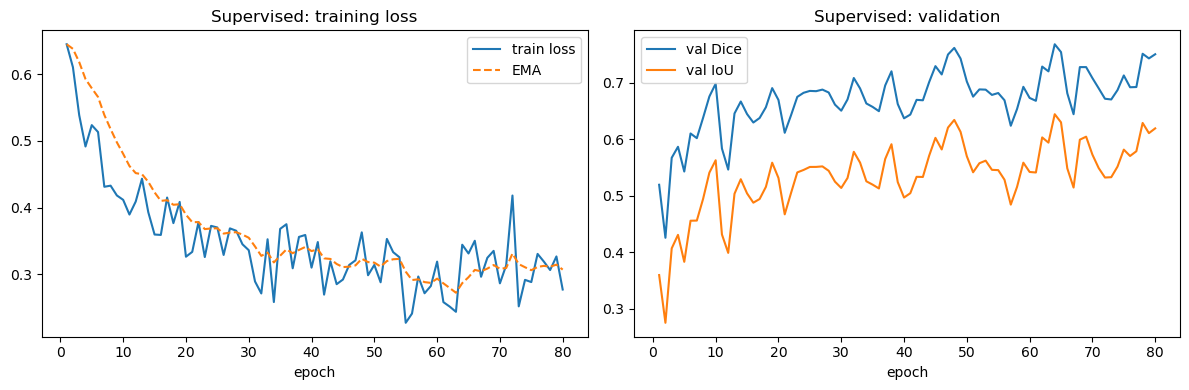

No SSL CSV found or file is empty: runs/exp02/ssl_metrics.csv


In [20]:
import os, pandas as pd, matplotlib.pyplot as plt

run_dir = CFG["paths"]["run_dir"]
sup_csv = os.path.join(run_dir, "sup_metrics.csv")
ssl_csv = os.path.join(run_dir, "ssl_metrics.csv")

def ema(x, alpha=0.2):
    if len(x) == 0: return x
    y = [x[0]]
    for v in x[1:]:
        y.append(alpha*v + (1-alpha)*y[-1])
    return y

# --- Supervised curves ---
if os.path.exists(sup_csv) and os.path.getsize(sup_csv) > 0:
    sup = pd.read_csv(sup_csv)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # loss
    ax[0].plot(sup.epoch, sup.loss_sup, label="train loss")
    ax[0].plot(sup.epoch, ema(sup.loss_sup.values), label="EMA", linestyle="--")
    ax[0].set_title("Supervised: training loss"); ax[0].set_xlabel("epoch"); ax[0].legend()
    # dice/iou
    ax[1].plot(sup.epoch, sup.val_dice, label="val Dice")
    ax[1].plot(sup.epoch, sup.val_iou,  label="val IoU")
    ax[1].set_title("Supervised: validation"); ax[1].set_xlabel("epoch"); ax[1].legend()
    plt.tight_layout(); plt.show()
else:
    print("No supervised CSV found or file is empty:", sup_csv)

# --- SSL curves ---
if os.path.exists(ssl_csv) and os.path.getsize(ssl_csv) > 0:
    ssl = pd.read_csv(ssl_csv)
    cols = [c for c in ["loss_sup","loss_consistency","lam","val_dice","val_iou"] if c in ssl.columns]
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    # supervised loss inside SSL
    if "loss_sup" in ssl:
        ax[0].plot(ssl.epoch, ssl.loss_sup, label="ssl sup loss")
        ax[0].plot(ssl.epoch, ema(ssl.loss_sup.values), label="EMA", linestyle="--")
        ax[0].set_title("SSL: supervised loss"); ax[0].set_xlabel("epoch"); ax[0].legend()
    # consistency loss
    if "loss_consistency" in ssl:
        ax[1].plot(ssl.epoch, ssl.loss_consistency, label="consistency")
        ax[1].plot(ssl.epoch, ema(ssl.loss_consistency.values), label="EMA", linestyle="--")
        ax[1].set_title("SSL: consistency loss"); ax[1].set_xlabel("epoch"); ax[1].legend()
    # val metrics
    if "val_dice" in ssl and "val_iou" in ssl:
        ax[2].plot(ssl.epoch, ssl.val_dice, label="val Dice")
        ax[2].plot(ssl.epoch, ssl.val_iou,  label="val IoU")
        ax[2].set_title("SSL: validation"); ax[2].set_xlabel("epoch"); ax[2].legend()
    plt.tight_layout(); plt.show()
else:
    print("No SSL CSV found or file is empty:", ssl_csv)
